In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio


In [2]:
%matplotlib widget

#### Load spiking data

In [3]:
spike_data = scio.loadmat('E:\\Dartmouth College Dropbox\\Manish Mohapatra\\NSB2025\\B4-2025-07-07\\clean_units_imec0.mat')
spike_trains = [x[0].squeeze() for x in spike_data['spike_train'][0]]

In [4]:
spike_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'depths', 'unit_ids', 'channel_ids', 'spike_train', 'shank_ids', 'mean_waveforms', 'peak_amp', 'valley_amp'])

#### Code to load stimulus presentation times

In [5]:
stim_times = np.loadtxt('E:\\Dartmouth College Dropbox\\Manish Mohapatra\\NSB2025\\B4-2025-07-07\\XA1_ON.txt', dtype='float')
con_indices = [1,3,5,7,9,11,13,15,17,19]
pos_indices = [0,6,8,12,16]
neg_indices = [2,4,10,14,18]

In [6]:
# Code to make bins from pre to post with bin_size
pre = -10
post = 60
bin_size = 0.1
bins = np.arange(pre-bin_size/2, post + bin_size/2, bin_size)


#### Heatmap code for each condition

In [7]:
# Code to plot trialized rasters for control condition
pre = -10
post = 60
bin_size = 0.5
buffer = 5
bins = np.arange(pre-buffer-bin_size/2, post+buffer+bin_size/2, bin_size)
spike_control_peths = []
spike_positive_peths = []
spike_negative_peths = []
for st in spike_trains:
    trialized_st = []
    # Trialify data for control condition
    for idx in con_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre) & (bins[:-1] <= post)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    con_peth = np.mean(trialized_st, axis=0)
    spike_control_peths.append(con_peth)
    
    trialized_st = []
    # Get data for postive condition
    for idx in pos_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre) & (bins[:-1] <= post)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    pos_peth = np.mean(trialized_st, axis=0)
    spike_positive_peths.append(pos_peth)
    
    trialized_st = []
    # Get data for negative condition
    for idx in neg_indices:
        this_stim = stim_times[idx]
        keep = (st > this_stim+pre-buffer) & (st < this_stim+post+buffer)
        this_trial_st = st[keep]
        this_trial_st -= this_stim
        # bin the spike train
        binned_st = np.histogram(this_trial_st, bins=bins)[0]
        # Keep bins that correspond to the pre and post time
        binned_st = binned_st[(bins[:-1] >= pre) & (bins[:-1] <= post)]
        trialized_st.append(binned_st)
    trialized_st = np.vstack(trialized_st)
    neg_peth = np.mean(trialized_st, axis=0)
    spike_negative_peths.append(neg_peth)

# Normalize the peths and append them
norm_spike_control_peths = [(x - np.min(x))/(np.max(x) - np.min(x)) for x in spike_control_peths]
spike_control_peths = np.vstack(spike_control_peths)
norm_control_spike_control_peths = np.vstack(norm_spike_control_peths)

norm_spike_positive_peths = [(x - np.min(x))/(np.max(x) - np.min(x)) for x in spike_positive_peths]
spike_positive_peths = np.vstack(spike_positive_peths)
norm_positive_spike_control_peths = np.vstack(norm_spike_positive_peths)

norm_spike_negative_peths = [(x - np.min(x))/(np.max(x) - np.min(x)) for x in spike_negative_peths]
spike_negative_peths = np.vstack(spike_negative_peths)
norm_negative_spike_control_peths = np.vstack(norm_spike_negative_peths)

Text(0.5, 1.0, 'Negative Condition')

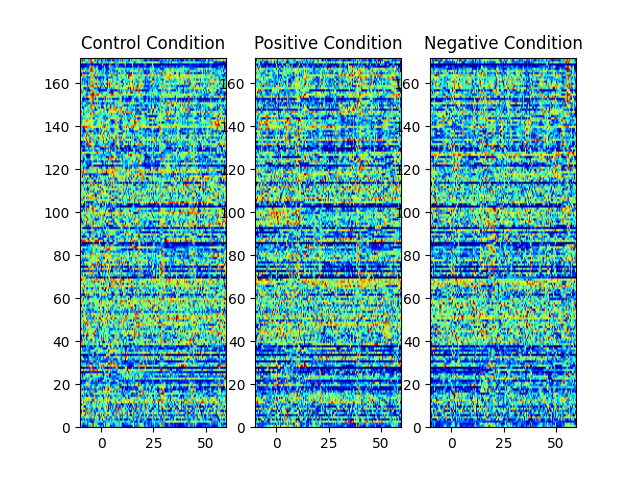

In [8]:
# Plot heatmap for control spike_control_peths after normalizing each row
display_bins = np.arange(pre-bin_size/2, post+bin_size/2, bin_size)
fig, ax = plt.subplots(1,3)
ax[0].imshow(norm_spike_control_peths, aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_control_peths.shape[0]])
ax[1].imshow(norm_spike_positive_peths, aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_positive_peths.shape[0]])
ax[2].imshow(norm_spike_negative_peths, aspect='auto', cmap='jet', extent=[display_bins[0], display_bins[-1], 0, spike_negative_peths.shape[0]])
ax[0].set_title('Control Condition')
ax[1].set_title('Positive Condition')
ax[2].set_title('Negative Condition')